<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/NY_baselineAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

New york state has reduced the Covid-19 cases. We have investigated the mask, social distancing, mobility data for NY state

In [2]:
!pip install wget


  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=e9e7c1b238b406e4f9b8514bf2f79853313ae3a0d8ba64d613da4b0e1062ff4b
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!ls  '/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/'

CA_combined_Sep09.csv
CA_Covid-19.csv
CA-CovidAug22.csv
CA_labeledData_Sep09
CA_labeledData_Sep18.csv
CA_labeledData_Sep20.csv
CA_labeledData_Sep22.csv
CA_sd_inertia_labeledData_Sep09
CA_sd_inertia_labeledData_Sep18.csv
CA_sd_inertia_labeledData_Sep20.csv
CA_sd_inertia_labeledData_Sep22.csv
CA_socialDistancingInertiaData_Sep09.csv
Maryland_University_SocialDistancing_Data
mask_rule.csv
mask_rule_data.csv
Newyork_combinedAug22.csv
Newyork_combined.csv
NY_Covid-19.csv
NY-CovidAug21.csv
NY-CovidAug22.csv
NY_labeledData_Aug23.csv
NY_labeledData_Aug27.csv
NY_labeledData_Sep13.csv
NY_sd_inertia_labeledData_Aug26.csv
NY_sd_inertia_labeledData_Aug27.csv
NY_sd_inertia_labeledData_Sep13.csv
NY_socialDistancingInertiaDataAug25.csv
queens_all_combined.csv
queens_all_filtered.csv
Queens_county.csv
Social_Distancing_Inertia_County.csv
TX_combined_Sep10.csv
TX-Covid_Sep10.csv
TX_labeledData_Sep16.csv
TX_labeledData_Sep17.csv
TX_sd_inertia_labeledData_Sep18.csv
TX_socialDistancingInertiaData_Sep10.csv

In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import wget
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBClassifier
from sklearn.mixture import GaussianMixture

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
import warnings; warnings.simplefilter('ignore')

## County Population

In [7]:
US_population_filename = wget.download('https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_county_population_usafacts.csv')
county_population_US = pd.read_csv(US_population_filename,low_memory=False)
print(county_population_US.shape)

county_population_US.head(2)

(3195, 4)


,countyFIPS,County Name,State,population
0,0,Statewide Unallocated,AL,0
1,1001,Autauga County,AL,55869


In [8]:
ny_population = county_population_US[county_population_US['State'] == 'NY']
print(ny_population.shape)
ny_population.head(2)

(64, 4)


,countyFIPS,County Name,State,population
1861,0,Statewide Unallocated,NY,0
1862,0,New York City Unallocated,NY,0


In [9]:
ny_population['County Name'].unique()

array(['Statewide Unallocated', 'New York City Unallocated',
       'Albany County', 'Allegany County', 'Bronx County',
       'Broome County', 'Cattaraugus County', 'Cayuga County',
       'Chautauqua County', 'Chemung County', 'Chenango County',
       'Clinton County', 'Columbia County', 'Cortland County',
       'Delaware County', 'Dutchess County', 'Erie County',
       'Essex County', 'Franklin County', 'Fulton County',
       'Genesee County', 'Greene County', 'Hamilton County',
       'Herkimer County', 'Jefferson County', 'Kings County',
       'Lewis County', 'Livingston County', 'Madison County',
       'Monroe County', 'Montgomery County', 'Nassau County',
       'New York County', 'Niagara County', 'Oneida County',
       'Onondaga County', 'Ontario County', 'Orange County',
       'Orleans County', 'Oswego County', 'Otsego County',
       'Putnam County', 'Queens County', 'Rensselaer County',
       'Richmond County', 'Rockland County', 'St. Lawrence County',
       'Sara

In [10]:
queens_county_population = ny_population[ny_population['County Name'] == 'Queens County']
queens_county_population

,countyFIPS,County Name,State,population
1903,36081,Queens County,NY,2253858


## Land Area 

In [11]:
landarea_filename = wget.download('https://raw.githubusercontent.com/ykzeng/covid-19/master/data/census-landarea-all.csv')
landarea_data = pd.read_csv(landarea_filename,low_memory=False)
print(landarea_data.shape)


(3195, 52)


In [12]:
landarea_data.head(2)

,fips,PST045212,PST040210,PST120212,POP010210,AGE135212,AGE295212,AGE775212,SEX255212,RHI125212,RHI225212,RHI325212,RHI425212,RHI525212,RHI625212,RHI725212,RHI825212,POP715211,POP645211,POP815211,EDU635211,EDU685211,VET605211,LFE305211,HSG010211,HSG445211,HSG096211,HSG495211,HSD410211,HSD310211,INC910211,INC110211,PVY020211,BZA010211,BZA110211,BZA115211,NES010211,SBO001207,SBO315207,SBO115207,SBO215207,SBO515207,SBO415207,SBO015207,MAN450207,WTN220207,RTN130207,RTN131207,AFN120207,BPS030212,LND110210,POP060210
0,0,313914040,308747508,1.7,308745538,6.4,23.5,13.7,50.8,77.9,13.1,1.2,5.1,0.2,2.4,16.9,63.0,84.6,12.8,20.3,85.4,28.2,22215303,25.4,132312404,66.1,25.9,186200,114761359,2.60,27915,52762,14.3,7354043,113425965,1.3,22491080,27092908,7.1,0.9,5.7,0.1,8.3,28.8,5319456312,4174286516,3917663456,12990,613795732,829658,3531905.43,87.4
1,1000,4822023,4779745,0.9,4779736,6.3,23.3,14.5,51.5,70.0,26.5,0.7,1.2,0.1,1.5,4.1,66.6,84.5,3.4,5.0,81.9,22.0,403982,24.0,2182088,70.7,15.5,120800,1831269,2.53,23483,42934,17.6,97743,1573138,0.3,321641,382350,14.8,0.8,1.8,0.1,1.2,28.1,112858843,52252752,57344851,12364,6426342,13506,50645.33,94.4


In [13]:
landarea_data['fips'].unique()

array([    0,  1000,  1001, ..., 56041, 56043, 56045])

In [14]:
#LND110210

landarea_data[landarea_data['fips'] == 36081]['LND110210']

1902    108.53
Name: LND110210, dtype: float64

#### Population density

In [15]:
density = 2253858/108.53

density

20767.142725513684

Queens population density

In [16]:
queens_population_density=pd.merge(queens_county_population,landarea_data,how='inner', left_on=['countyFIPS'], right_on = ['fips'])

In [17]:
queens_population_density['population_density']= queens_population_density['population']/queens_population_density['LND110210']
queens_population_density = queens_population_density[['fips','County Name', 'State', 'population','LND110210','population_density']].copy()
queens_population_density.tail(3)

,fips,County Name,State,population,LND110210,population_density
0,36081,Queens County,NY,2253858,108.53,20767.142726


## Mask data

In [18]:
mask_rule_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/mask_rule.csv',low_memory=False)
 
mask_rule_data.head()

,state_name,Law Date,Masks Required?,Type of Requirement,mask_required_rule,requirement_code
0,Louisiana,2020-07-13,Entire State,Everywhere in public where social distancing i...,0,3
1,Kentucky,2020-07-10,Entire State,Everywhere in public where social distancing i...,0,3
2,West Virginia,2020-07-07,Entire State,All Public Indoor Spaces (where social distanc...,0,1
3,Texas,2020-07-03,Entire State,Everywhere in public where social distancing i...,0,4
4,Kansas,2020-07-03,Entire State,Everywhere in public where social distancing i...,0,3


In [19]:
NY_mask_rule = mask_rule_data[mask_rule_data['state_name'] == 'New York']
NY_mask_rule

,state_name,Law Date,Masks Required?,Type of Requirement,mask_required_rule,requirement_code
22,New York,2020-04-15,Entire State,Everywhere in public where social distancing i...,0,3


In [20]:
mask_filename = wget.download('https://raw.githubusercontent.com/nytimes/covid-19-data/master/mask-use/mask-use-by-county.csv')
mask_filename

'mask-use-by-county.csv'

In [21]:

mask_data = pd.read_csv(mask_filename,low_memory=False)
print(mask_data.shape)

(3142, 6)


In [22]:
mask_data.head()

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,1001,0.053,0.074,0.134,0.295,0.444
1,1003,0.083,0.059,0.098,0.323,0.436
2,1005,0.067,0.121,0.120,0.201,0.491
3,1007,0.020,0.034,0.096,0.278,0.572
4,1009,0.053,0.114,0.180,0.194,0.459


In [23]:
mask_data[mask_data['COUNTYFP'] == 36081]

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
1868,36081,0.022,0.023,0.068,0.136,0.751


In [24]:
0.022 +	0.023	+0.068	+0.136+	0.751

1.0

## Mobility Data 

### Google mobility data

In [25]:
google_data_url = 'https://raw.githubusercontent.com/ActiveConclusion/COVID19_mobility/master/google_reports/mobility_report_US.csv'

google_filename = wget.download(google_data_url)
google_mobility_data = pd.read_csv(google_filename,low_memory=False)
google_mobility_data.head(2)

,state,county,date,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential
0,Total,Total,2020-02-15,6.0,2.0,15.0,3.0,2.0,-1.0
1,Total,Total,2020-02-16,7.0,1.0,16.0,2.0,0.0,-1.0


In [26]:
NY_GoogleMobility_data = google_mobility_data[google_mobility_data['state'] == 'New York']
print(NY_GoogleMobility_data.shape)
NY_GoogleMobility_data.tail(2)

(13640, 9)


,state,county,date,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential
348184,New York,Yates County,2020-09-20,NaN,NaN,NaN,NaN,3.0,NaN
348185,New York,Yates County,2020-09-21,NaN,NaN,NaN,NaN,-16.0,NaN


### Apple mobility data

In [27]:
apple_report_url = 'https://raw.githubusercontent.com/ActiveConclusion/COVID19_mobility/master/apple_reports/apple_mobility_report_US.csv'

apple_filename = wget.download(apple_report_url)
apple_mobility_data = pd.read_csv(apple_filename,low_memory=False)
apple_mobility_data.tail(2)

,state,county_and_city,geo_type,date,driving,transit,walking
571660,Wyoming,Uinta County,county,2020-09-22,132.76,NaN,NaN
571661,Wyoming,Uinta County,county,2020-09-23,121.02,NaN,NaN


In [28]:
NY_AppleMobility_data = apple_mobility_data[apple_mobility_data['state'] == 'New York']
print(NY_AppleMobility_data.shape)
NY_AppleMobility_data.tail(2)

(16989, 7)


,state,county_and_city,geo_type,date,driving,transit,walking
329709,New York,Yates County,county,2020-09-22,169.55,NaN,NaN
329710,New York,Yates County,county,2020-09-23,181.12,NaN,NaN


In [29]:
NY_AppleMobility_data['county'] = NY_AppleMobility_data['county_and_city']

In [30]:
NY_AppleMobility_data = NY_AppleMobility_data[['state','county','date','driving','transit','walking']]

NY_AppleMobility_data.tail(2)

,state,county,date,driving,transit,walking
329709,New York,Yates County,2020-09-22,169.55,NaN,NaN
329710,New York,Yates County,2020-09-23,181.12,NaN,NaN


In [31]:
NY_mobility_data = pd.merge(NY_GoogleMobility_data,NY_AppleMobility_data,how='outer' ,on=['state','county','date'])
NY_mobility_data.shape

(17075, 12)

In [32]:
NY_mobility_data = NY_mobility_data.fillna(0)
NY_mobility_data.tail()

,state,county,date,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,transit,walking
17070,New York,Yates County,2020-02-12,0.0,0.0,0.0,0.0,0.0,0.0,33.30,0.0,0.0
17071,New York,Yates County,2020-02-13,0.0,0.0,0.0,0.0,0.0,0.0,30.28,0.0,0.0
17072,New York,Yates County,2020-02-14,0.0,0.0,0.0,0.0,0.0,0.0,78.01,0.0,0.0
17073,New York,Yates County,2020-09-22,0.0,0.0,0.0,0.0,0.0,0.0,169.55,0.0,0.0
17074,New York,Yates County,2020-09-23,0.0,0.0,0.0,0.0,0.0,0.0,181.12,0.0,0.0


### Queens county mobility data

In [33]:
queens_mobility_data = NY_mobility_data[NY_mobility_data['county'] == 'Queens County']
print(queens_mobility_data.shape)
queens_mobility_data.tail()

(255, 12)


,state,county,date,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,transit,walking
15794,New York,Queens County,2020-02-12,0.0,0.0,0.0,0.0,0.0,0.0,3.27,-6.03,-1.06
15795,New York,Queens County,2020-02-13,0.0,0.0,0.0,0.0,0.0,0.0,14.60,-0.74,-1.02
15796,New York,Queens County,2020-02-14,0.0,0.0,0.0,0.0,0.0,0.0,34.10,6.81,15.92
15797,New York,Queens County,2020-09-22,0.0,0.0,0.0,0.0,0.0,0.0,15.43,-41.87,4.29
15798,New York,Queens County,2020-09-23,0.0,0.0,0.0,0.0,0.0,0.0,19.10,-41.17,6.50


In [34]:
queens_mobility_data.head()

,state,county,date,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,transit,walking
8800,New York,Queens County,2020-02-15,-2.0,-5.0,-11.0,-5.0,2.0,0.0,15.43,1.65,13.42
8801,New York,Queens County,2020-02-16,1.0,-5.0,5.0,-5.0,-1.0,-1.0,-2.23,-12.84,-2.75
8802,New York,Queens County,2020-02-17,7.0,0.0,39.0,-16.0,-38.0,10.0,1.85,3.31,5.37
8803,New York,Queens County,2020-02-18,0.0,-4.0,-7.0,-5.0,-9.0,3.0,4.02,2.06,2.32
8804,New York,Queens County,2020-02-19,3.0,-2.0,14.0,-5.0,-9.0,2.0,5.73,2.69,3.63


## Social Distancing metric 

In [35]:
socialdistancing_url = 'https://raw.githubusercontent.com/descarteslabs/DL-COVID-19/master/DL-us-mobility-daterow.csv'

socialdistancing_file = wget.download(socialdistancing_url)
socialdistancing_data = pd.read_csv(socialdistancing_file,low_memory=False)
socialdistancing_data.tail(2)



,date,country_code,admin_level,admin1,admin2,fips,samples,m50,m50_index
552182,2020-09-21,US,2,Wyoming,Uinta County,56041.0,612,6.411,204
552183,2020-09-22,US,2,Wyoming,Uinta County,56041.0,622,4.050,129


In [36]:
newyork_socialdistancing_data= socialdistancing_data[(socialdistancing_data['admin1']=='New York') &
                                           (socialdistancing_data['admin_level']== 2)]

newyork_socialdistancing_data.head()

,date,country_code,admin_level,admin1,admin2,fips,samples,m50,m50_index
320988,2020-03-01,US,2,New York,Albany County,36001.0,4095,2.616,54
320989,2020-03-02,US,2,New York,Albany County,36001.0,4376,4.680,97
320990,2020-03-03,US,2,New York,Albany County,36001.0,4686,4.778,100
320991,2020-03-04,US,2,New York,Albany County,36001.0,4842,4.486,93
320992,2020-03-05,US,2,New York,Albany County,36001.0,4548,5.129,107


In [37]:
queens_social_distancing = newyork_socialdistancing_data[newyork_socialdistancing_data['admin2'] == 'Queens County']
print(queens_social_distancing.shape)
queens_social_distancing.head()

(204, 9)


,date,country_code,admin_level,admin1,admin2,fips,samples,m50,m50_index
328944,2020-03-01,US,2,New York,Queens County,36081.0,26218,1.339,35
328945,2020-03-02,US,2,New York,Queens County,36081.0,27435,3.813,99
328946,2020-03-03,US,2,New York,Queens County,36081.0,28459,3.747,98
328947,2020-03-04,US,2,New York,Queens County,36081.0,29480,3.822,99
328948,2020-03-05,US,2,New York,Queens County,36081.0,27602,4.052,106


# Load Social Distancing Inertia Data [Maryland University]

In [38]:
maryland_sd_inertia = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/Social_Distancing_Inertia_County.csv',low_memory=False)
maryland_sd_inertia.head()

,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases
0,1001,Autauga County,1,54,27,2.25,38.8,1.2,24.7,0.25,2.00,0,55601,-22.5,1/1/2020,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,39.0,12,0.0,0,0.9,2.7,3.2,0.3,0.0,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0
1,1001,Autauga County,1,25,18,2.83,43.5,0.9,37.6,0.62,2.21,0,55601,-14.3,1/2/2020,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,39.0,12,0.0,0,0.9,2.7,3.2,0.3,0.0,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0
2,1001,Autauga County,1,15,15,3.18,42.2,1.0,40.3,0.62,2.57,0,55601,-0.4,1/3/2020,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,39.0,12,0.0,0,0.9,2.7,3.2,0.3,0.0,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0
3,1001,Autauga County,1,33,20,2.85,43.9,1.2,29.5,0.33,2.52,0,55601,-2.3,1/4/2020,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,39.0,12,0.0,0,0.9,2.7,3.2,0.3,0.0,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0
4,1001,Autauga County,1,40,22,2.56,42.8,1.2,30.9,0.23,2.33,0,55601,-9.7,1/5/2020,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,39.0,12,0.0,0,0.9,2.7,3.2,0.3,0.0,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0


## Fixdate column of Social Distancing inertia

In [39]:
def fixDate(x, appendTwenty):
  arr = x.split('/')
  m = arr[0]
  d = arr[1]
  y = arr[2]

  if int(m) < 10:
    m = '0'+str(m)
  if int(d) < 10:
    d = '0'+str(d)
  if appendTwenty == True:
    return '20'+y+'-'+m+'-'+d
  else:
      return y+'-'+m+'-'+d

In [40]:
maryland_sd_inertia['date'] = maryland_sd_inertia['date'].apply(lambda x: fixDate(x,False))
maryland_sd_inertia.reset_index(drop=True)

,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases
0,1001,Autauga County,1,54,27,2.25,38.8,1.2,24.7,0.25,2.00,0,55601,-22.5,2020-01-01,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,39.0,12,0.0,0,0.9,2.7,3.2,0.30,0.0,0.0000,0.00,0,47.100000,0.0,0.00,0.00,0,0
1,1001,Autauga County,1,25,18,2.83,43.5,0.9,37.6,0.62,2.21,0,55601,-14.3,2020-01-02,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,39.0,12,0.0,0,0.9,2.7,3.2,0.30,0.0,0.0000,0.00,0,47.100000,0.0,0.00,0.00,0,0
2,1001,Autauga County,1,15,15,3.18,42.2,1.0,40.3,0.62,2.57,0,55601,-0.4,2020-01-03,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,39.0,12,0.0,0,0.9,2.7,3.2,0.30,0.0,0.0000,0.00,0,47.100000,0.0,0.00,0.00,0,0
3,1001,Autauga County,1,33,20,2.85,43.9,1.2,29.5,0.33,2.52,0,55601,-2.3,2020-01-04,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,39.0,12,0.0,0,0.9,2.7,3.2,0.30,0.0,0.0000,0.00,0,47.100000,0.0,0.00,0.00,0,0
4,1001,Autauga County,1,40,22,2.56,42.8,1.2,30.9,0.23,2.33,0,55601,-9.7,2020-01-05,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,39.0,12,0.0,0,0.9,2.7,3.2,0.30,0.0,0.0000,0.00,0,47.100000,0.0,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732081,56037,Sweetwater County,56,19,22,4.62,25.1,10.5,63.0,0.58,4.04,0,43051,37.8,2020-08-20,2.52,17,73008,0.8,16.0,51.87,4,3,134,3.76,0.50,0.017,47.0,6,17.1,105,3.8,12.6,26.2,1.51,0.3,0.0542,2.19,0,37.716682,5.4,111.08,1.31,3,90
732082,56039,Teton County,56,33,21,4.12,33.0,20.7,30.2,0.39,3.73,4,23081,0.8,2020-08-20,4.05,20,83831,1.1,14.9,51.65,5,7,297,3.76,0.50,0.017,47.0,16,17.1,105,3.8,12.6,26.2,1.51,0.3,0.1155,2.19,0,37.716682,5.4,111.08,1.31,3,100
732083,56041,Uinta County,56,21,20,4.44,36.8,24.5,79.0,0.65,3.79,0,20299,52.1,2020-08-20,3.60,18,58235,0.1,9.1,50.97,10,5,147,3.76,0.50,0.017,47.0,9,17.1,105,3.8,12.6,26.2,1.51,0.3,0.0985,2.19,14,37.716682,5.4,111.08,1.31,3,80
732084,56043,Washakie County,56,35,41,3.34,19.0,2.1,59.4,0.85,2.50,2,7885,20.9,2020-08-20,0.03,28,53426,0.0,14.2,50.89,4,3,205,3.76,0.50,0.017,47.0,73,17.1,105,3.8,12.6,26.2,1.51,0.3,0.2536,2.19,5,37.716682,5.4,111.08,1.31,3,7


# Load Data for covid-19 cases

In [41]:
!ls /content/drive/'Shared drives'/'CMPE 295- Master Project'/Covid19-data

CA_combined_Sep09.csv
CA_Covid-19.csv
CA-CovidAug22.csv
CA_labeledData_Sep09
CA_labeledData_Sep18.csv
CA_labeledData_Sep20.csv
CA_labeledData_Sep22.csv
CA_sd_inertia_labeledData_Sep09
CA_sd_inertia_labeledData_Sep18.csv
CA_sd_inertia_labeledData_Sep20.csv
CA_sd_inertia_labeledData_Sep22.csv
CA_socialDistancingInertiaData_Sep09.csv
Maryland_University_SocialDistancing_Data
mask_rule.csv
mask_rule_data.csv
Newyork_combinedAug22.csv
Newyork_combined.csv
NY_Covid-19.csv
NY-CovidAug21.csv
NY-CovidAug22.csv
NY_labeledData_Aug23.csv
NY_labeledData_Aug27.csv
NY_labeledData_Sep13.csv
NY_sd_inertia_labeledData_Aug26.csv
NY_sd_inertia_labeledData_Aug27.csv
NY_sd_inertia_labeledData_Sep13.csv
NY_socialDistancingInertiaDataAug25.csv
queens_all_combined.csv
queens_all_filtered.csv
Queens_county.csv
Social_Distancing_Inertia_County.csv
TX_combined_Sep10.csv
TX-Covid_Sep10.csv
TX_labeledData_Sep16.csv
TX_labeledData_Sep17.csv
TX_sd_inertia_labeledData_Sep18.csv
TX_socialDistancingInertiaData_Sep10.csv

In [42]:
queens_covidcases = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/Queens_county.csv', low_memory =False)
queens_covidcases.tail()

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths
201,8/5/20,New York,36081.0,0,0,636,29
202,8/6/20,New York,36081.0,0,0,703,2
203,8/7/20,New York,36081.0,0,0,714,4
204,8/8/20,New York,36081.0,0,0,703,8
205,8/9/20,New York,36081.0,0,0,515,6


## Fix Date

In [43]:
queens_covidcases['Date'] = queens_covidcases['Date'].apply(lambda x: fixDate(x,True))
queens_covidcases.reset_index(drop=True)

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths
0,2020-01-22,New York,36081.0,0,0,0,0
1,2020-01-23,New York,36081.0,0,0,0,0
2,2020-01-24,New York,36081.0,0,0,0,0
3,2020-01-25,New York,36081.0,0,0,0,0
4,2020-01-26,New York,36081.0,0,0,0,0
...,...,...,...,...,...,...,...
201,2020-08-05,New York,36081.0,0,0,636,29
202,2020-08-06,New York,36081.0,0,0,703,2
203,2020-08-07,New York,36081.0,0,0,714,4
204,2020-08-08,New York,36081.0,0,0,703,8


# Formula Computation from Baseline Value

## For Social Distancing Metric

In [44]:
start_date = '2020-05-05'
end_date = '2020-05-13'
#start_date = '2020-02-17'
#end_date = '2020-03-07'
mask = (queens_social_distancing['date'] >= start_date) & (queens_social_distancing['date'] <= end_date)

In [45]:
df_queens_social_distancing =  queens_social_distancing.loc[mask]
df_queens_social_distancing

,date,country_code,admin_level,admin1,admin2,fips,samples,m50,m50_index
329008,2020-05-05,US,2,New York,Queens County,36081.0,26633,0.021,0
329009,2020-05-06,US,2,New York,Queens County,36081.0,27819,0.020,0
329010,2020-05-07,US,2,New York,Queens County,36081.0,29651,0.022,0
329011,2020-05-08,US,2,New York,Queens County,36081.0,27390,0.019,0
329012,2020-05-09,US,2,New York,Queens County,36081.0,27340,0.017,0
329013,2020-05-10,US,2,New York,Queens County,36081.0,27660,0.017,0
329014,2020-05-11,US,2,New York,Queens County,36081.0,27697,0.017,0
329015,2020-05-12,US,2,New York,Queens County,36081.0,29950,0.021,0
329016,2020-05-13,US,2,New York,Queens County,36081.0,28052,0.020,0


In [46]:
queens_social_distancing_base = (
    df_queens_social_distancing
    .pipe(lambda x: x.assign(gains_pctg=x["m50"]))
    .groupby(['admin1','admin2','fips'])
    .agg({"gains_pctg": "median"})
    .reset_index()
    .rename(columns={"gains_pctg": "m50"})
)
queens_social_distancing_base

,admin1,admin2,fips,m50
0,New York,Queens County,36081.0,0.02


In [47]:
queens_social_distancing_base.at[0,'m50']

0.02

computing formula : m50_baseline = 100 * m50/queens_social_distancing_base.at[0,'m50']

In [48]:
socialdistancing_data['m50_baseline'] = socialdistancing_data['m50'].apply(lambda x: 100 * (x/queens_social_distancing_base.at[0,'m50']))


In [49]:
socialdistancing_data[socialdistancing_data['admin1'] == 'California']

,date,country_code,admin_level,admin1,admin2,fips,samples,m50,m50_index,m50_baseline
33520,2020-03-01,US,1,California,NaN,6.0,451282,4.122,60,20610.0
33521,2020-03-02,US,1,California,NaN,6.0,457175,6.725,98,33625.0
33522,2020-03-03,US,1,California,NaN,6.0,472598,6.842,100,34210.0
33523,2020-03-04,US,1,California,NaN,6.0,481255,6.827,99,34135.0
33524,2020-03-05,US,1,California,NaN,6.0,458159,7.270,106,36350.0
...,...,...,...,...,...,...,...,...,...,...
44665,2020-09-18,US,2,California,Yuba County,6115.0,1206,7.120,75,35600.0
44666,2020-09-19,US,2,California,Yuba County,6115.0,1129,5.276,55,26380.0
44667,2020-09-20,US,2,California,Yuba County,6115.0,1189,3.133,33,15665.0
44668,2020-09-21,US,2,California,Yuba County,6115.0,978,4.210,44,21050.0


# Rolling Average for Social Distancing

In [50]:
queens_social_distancing = newyork_socialdistancing_data[newyork_socialdistancing_data['admin2'] == 'Queens County']
queens_social_distancing.head(3)

,date,country_code,admin_level,admin1,admin2,fips,samples,m50,m50_index
328944,2020-03-01,US,2,New York,Queens County,36081.0,26218,1.339,35
328945,2020-03-02,US,2,New York,Queens County,36081.0,27435,3.813,99
328946,2020-03-03,US,2,New York,Queens County,36081.0,28459,3.747,98


In [51]:
queens_social_distancing.iloc[:,8]

328944     35
328945     99
328946     98
328947     99
328948    106
         ... 
329143     47
329144     29
329145     12
329146     22
329147     23
Name: m50_index, Length: 204, dtype: int64

In [52]:
import pandas as pd
import altair as alt

base_queens = alt.Chart(queens_social_distancing).mark_bar().encode(
    x='monthdate(date):O',
).properties(
    width=500
)

In [53]:
base_queens.encode(y="m50_index").properties(title='Queens County Social Distancing Mteric(m50_index)')

alt.Chart(...)

In [54]:
queens_social_distancing['rolling_average'] = queens_social_distancing.iloc[:,8].rolling(window=7).mean()

base_queens = alt.Chart(queens_social_distancing).mark_bar().encode(
    x='monthdate(date):O',
).properties(
    width=500
)


In [55]:
queens_social_distancing.tail(10)

,date,country_code,admin_level,admin1,admin2,fips,samples,m50,m50_index,rolling_average
329138,2020-09-13,US,2,New York,Queens County,36081.0,31574,0.416,10,25.714286
329139,2020-09-14,US,2,New York,Queens County,36081.0,34364,1.285,33,28.571429
329140,2020-09-15,US,2,New York,Queens County,36081.0,32320,1.035,27,28.142857
329141,2020-09-16,US,2,New York,Queens County,36081.0,34322,1.252,32,28.428571
329142,2020-09-17,US,2,New York,Queens County,36081.0,34351,1.284,33,29.571429
329143,2020-09-18,US,2,New York,Queens County,36081.0,30949,1.804,47,30.142857
329144,2020-09-19,US,2,New York,Queens County,36081.0,30732,1.116,29,30.142857
329145,2020-09-20,US,2,New York,Queens County,36081.0,30913,0.466,12,30.428571
329146,2020-09-21,US,2,New York,Queens County,36081.0,29823,0.868,22,28.857143
329147,2020-09-22,US,2,New York,Queens County,36081.0,31539,0.892,23,28.285714


In [56]:
base_queens.encode(y="rolling_average").properties(title='Queens County- 7 day rolling average (Social Distancing Metric)')


alt.Chart(...)

In [57]:
bar = base_queens.mark_bar().encode(y="m50_index")

line =  base_queens.mark_line(color='red').encode(
    y='rolling_average'
)

(bar + line).properties(title='Queens County - Social Distancing Metric and rolling average ',width=600)|base_queens.encode(y="rolling_average").properties(title='Queens County- 7 day rolling average (Social Distancing Metric)')

alt.HConcatChart(...)

## Overlap PLot

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

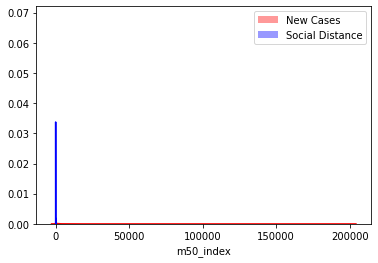

In [59]:
# Method 1: on the same Axis
sns.distplot( queens_covidcases["New cases"] , color="red", label="New Cases")
sns.distplot( (queens_social_distancing["m50_index"]) , color="blue", label="Social Distance")
plt.legend()
 
plt.show()

# Merge Social Distancing and 'New Cases'

In [60]:
merged_socialDistancing = pd.merge(queens_covidcases,queens_social_distancing,how='inner', left_on=['Date'], right_on = ['date'])

In [61]:
merged_socialDistancing.tail()

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths,date,country_code,admin_level,admin1,admin2,fips,samples,m50,m50_index,rolling_average
160,2020-08-05,New York,36081.0,0,0,636,29,2020-08-05,US,2,New York,Queens County,36081.0,36554,0.906,23,14.285714
161,2020-08-06,New York,36081.0,0,0,703,2,2020-08-06,US,2,New York,Queens County,36081.0,40105,0.789,20,14.571429
162,2020-08-07,New York,36081.0,0,0,714,4,2020-08-07,US,2,New York,Queens County,36081.0,37762,0.857,22,14.857143
163,2020-08-08,New York,36081.0,0,0,703,8,2020-08-08,US,2,New York,Queens County,36081.0,32671,0.714,18,14.714286
164,2020-08-09,New York,36081.0,0,0,515,6,2020-08-09,US,2,New York,Queens County,36081.0,33830,0.221,5,15.285714


In [62]:
merged_socialDistancing['m50_multiplied'] = merged_socialDistancing['m50_index'] * 1000

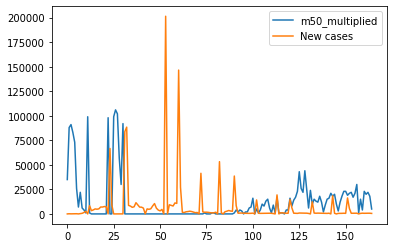

In [63]:
merged_socialDistancing[['m50_multiplied','New cases']].plot()

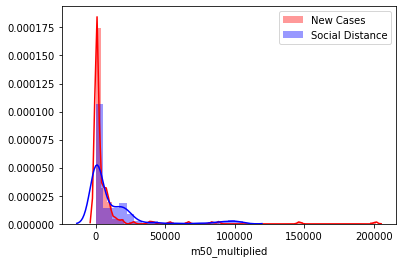

In [64]:
# Method 1: on the same Axis
sns.distplot( merged_socialDistancing["New cases"] , color="red", label="New Cases")
sns.distplot( (merged_socialDistancing["m50_multiplied"]) , color="blue", label="Social Distance")
plt.legend()
 
plt.show()

In [65]:
## Moving avg

merged_socialDistancing['rolling_avg_newcases'] = merged_socialDistancing.iloc[:,5].rolling(window=7).mean() 

In [66]:
merged_socialDistancing['rolling_average_multiplies'] = merged_socialDistancing['rolling_average'] * 1000

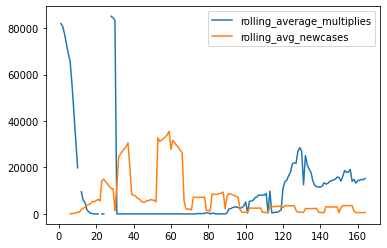

In [67]:
merged_socialDistancing[['rolling_average_multiplies','rolling_avg_newcases']].plot()

## Twin plot

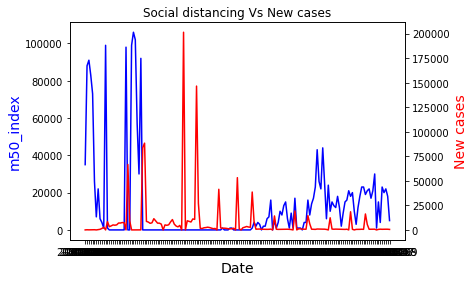

In [68]:
fig,ax = plt.subplots()
# make a plot
ax.plot(merged_socialDistancing.date, merged_socialDistancing.m50_multiplied, color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("m50_index",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(merged_socialDistancing.date, merged_socialDistancing["New cases"],color="red")
ax2.set_ylabel("New cases",color="red",fontsize=14)
plt.title("Social distancing Vs New cases")

plt.show()

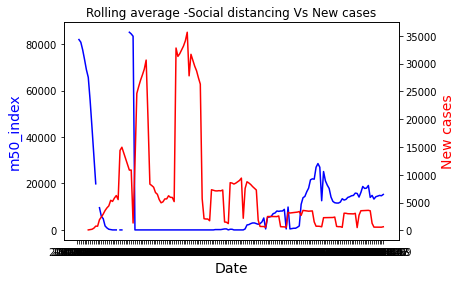

In [69]:
fig,ax = plt.subplots()
# make a plot
ax.plot(merged_socialDistancing.date, merged_socialDistancing.rolling_average_multiplies, color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("m50_index",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(merged_socialDistancing.date, merged_socialDistancing["rolling_avg_newcases"],color="red")
ax2.set_ylabel("New cases",color="red",fontsize=14)
plt.title("Rolling average -Social distancing Vs New cases")
plt.show()

## Correlation

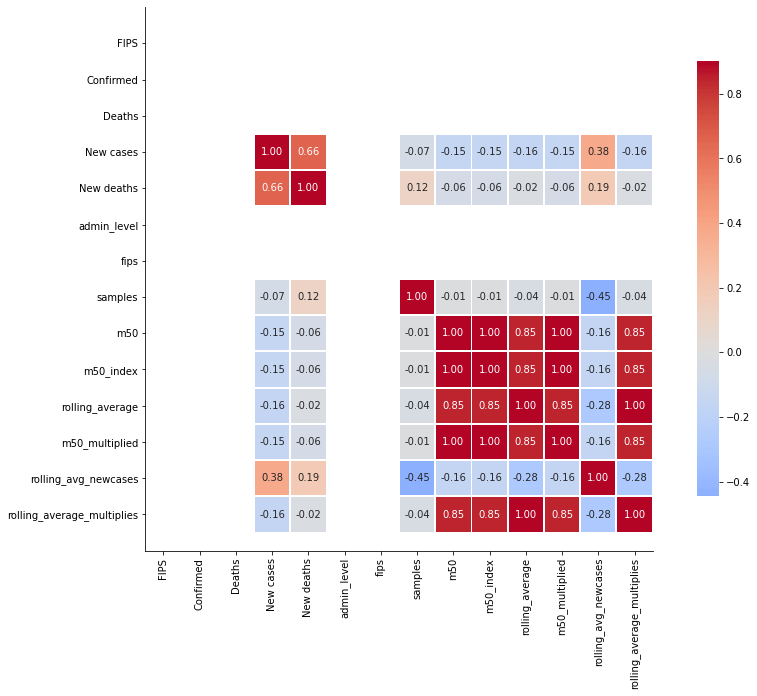

In [70]:
corr = merged_socialDistancing.corr()
g = sns.heatmap(corr, vmax=.9, center=0,
               square=True, linewidths=.9, cbar_kws={"shrink": .8}, annot=True, fmt='.2f', cmap='coolwarm')
bottom, top = g.get_ylim()
g.set_ylim(bottom + 0.5, top - 0.5)
sns.despine()
g.figure.set_size_inches(16, 10)

# Merge Social Distancing and mobility data

In [71]:
queens_mobility_data.head()

,state,county,date,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,transit,walking
8800,New York,Queens County,2020-02-15,-2.0,-5.0,-11.0,-5.0,2.0,0.0,15.43,1.65,13.42
8801,New York,Queens County,2020-02-16,1.0,-5.0,5.0,-5.0,-1.0,-1.0,-2.23,-12.84,-2.75
8802,New York,Queens County,2020-02-17,7.0,0.0,39.0,-16.0,-38.0,10.0,1.85,3.31,5.37
8803,New York,Queens County,2020-02-18,0.0,-4.0,-7.0,-5.0,-9.0,3.0,4.02,2.06,2.32
8804,New York,Queens County,2020-02-19,3.0,-2.0,14.0,-5.0,-9.0,2.0,5.73,2.69,3.63


In [72]:
queens_covidcases.head()

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths
0,2020-01-22,New York,36081.0,0,0,0,0
1,2020-01-23,New York,36081.0,0,0,0,0
2,2020-01-24,New York,36081.0,0,0,0,0
3,2020-01-25,New York,36081.0,0,0,0,0
4,2020-01-26,New York,36081.0,0,0,0,0


In [73]:
merged_mobility = pd.merge(queens_covidcases,queens_mobility_data,how='inner', left_on=['Date'], right_on = ['date'])

merged_mobility.head()


,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths,state,county,date,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,transit,walking
0,2020-01-22,New York,36081.0,0,0,0,0,New York,Queens County,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,1.02,2.47,-0.77
1,2020-01-23,New York,36081.0,0,0,0,0,New York,Queens County,2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,5.10,1.47,0.51
2,2020-01-24,New York,36081.0,0,0,0,0,New York,Queens County,2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,19.35,9.49,18.07
3,2020-01-25,New York,36081.0,0,0,0,0,New York,Queens County,2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,8.11,-3.40,6.33
4,2020-01-26,New York,36081.0,0,0,0,0,New York,Queens County,2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,-9.16,-15.04,-8.90


## Twin plot

### Retail and Recreation Vs new cases

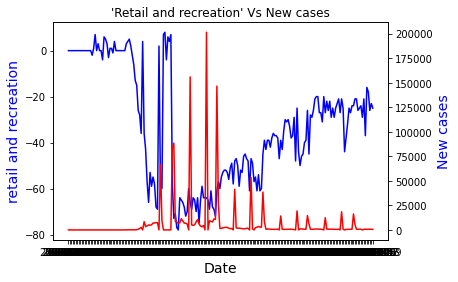

In [74]:
fig,ax = plt.subplots()
# make a plot
ax.plot(merged_mobility.date, merged_mobility['retail and recreation'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("retail and recreation",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(merged_mobility.date, merged_mobility["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'Retail and recreation' Vs New cases")

plt.show()

### Residential Vs New cases

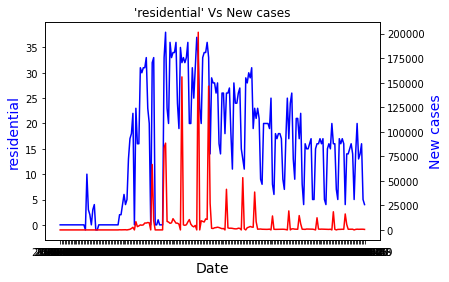

In [75]:
fig,ax = plt.subplots()
# make a plot
ax.plot(merged_mobility.date, merged_mobility['residential'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("residential",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(merged_mobility.date, merged_mobility["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'residential' Vs New cases")

plt.show()

### Workplaces Vs New cases

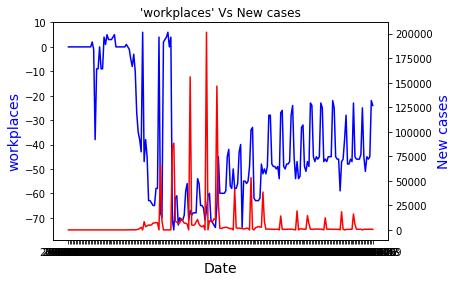

In [76]:
fig,ax = plt.subplots()
# make a plot
ax.plot(merged_mobility.date, merged_mobility['workplaces'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("workplaces",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(merged_mobility.date, merged_mobility["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'workplaces' Vs New cases")

plt.show()

### 'grocery and pharmacy' Vs New Cases

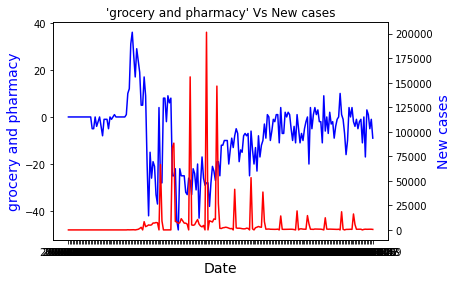

In [77]:


fig,ax = plt.subplots()
# make a plot
ax.plot(merged_mobility.date, merged_mobility['grocery and pharmacy'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("grocery and pharmacy",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(merged_mobility.date, merged_mobility["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'grocery and pharmacy' Vs New cases")

plt.show()

### parks Vs New cases

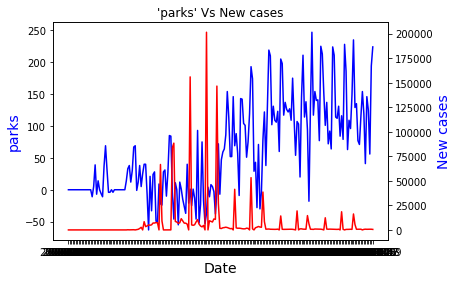

In [78]:

fig,ax = plt.subplots()
# make a plot
ax.plot(merged_mobility.date, merged_mobility['parks'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("parks",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(merged_mobility.date, merged_mobility["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'parks' Vs New cases")

plt.show()

### 'transit stations' Vs New cases

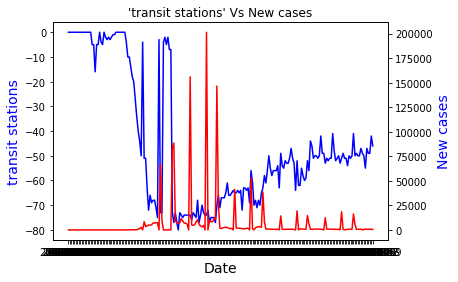

In [79]:

fig,ax = plt.subplots()
# make a plot
ax.plot(merged_mobility.date, merged_mobility['transit stations'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("transit stations",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(merged_mobility.date, merged_mobility["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'transit stations' Vs New cases")

plt.show()

### Driving Vs New cases

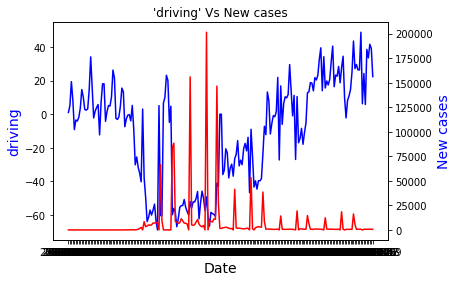

In [80]:
fig,ax = plt.subplots()
# make a plot
ax.plot(merged_mobility.date, merged_mobility['driving'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("driving",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(merged_mobility.date, merged_mobility["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'driving' Vs New cases")

plt.show()

### transit Vs New cases

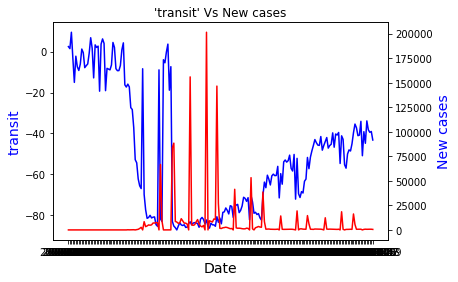

In [81]:
fig,ax = plt.subplots()
# make a plot
ax.plot(merged_mobility.date, merged_mobility['transit'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("transit",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(merged_mobility.date, merged_mobility["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'transit' Vs New cases")

plt.show()

### walking Vs New cases

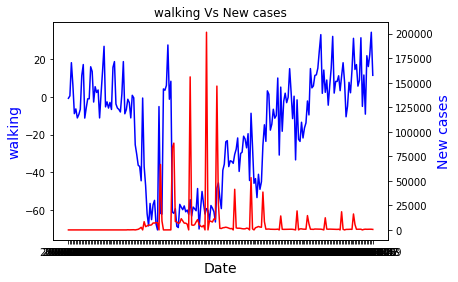

In [82]:
fig,ax = plt.subplots()
# make a plot
ax.plot(merged_mobility.date, merged_mobility['walking'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("walking",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(merged_mobility.date, merged_mobility["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("walking Vs New cases")

plt.show()

# Merge Social Distancing, mobility data and Covid Cases

In [83]:
merged_mobility.tail(1)

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths,state,county,date,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,transit,walking
205,2020-08-09,New York,36081.0,0,0,515,6,New York,Queens County,2020-08-09,-25.0,-9.0,224.0,-46.0,-24.0,4.0,22.34,-43.24,11.39


In [84]:
merged_mobility_social_covid=pd.merge(merged_mobility,queens_social_distancing,how='inner', left_on=['Date','county'], right_on = ['date','admin2'])

In [85]:
merged_mobility_social_covid.tail(3)


,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths,state,county,date_x,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,transit,walking,date_y,country_code,admin_level,admin1,admin2,fips,samples,m50,m50_index,rolling_average
162,2020-08-07,New York,36081.0,0,0,714,4,New York,Queens County,2020-08-07,-26.0,-5.0,56.0,-49.0,-45.0,16.0,41.58,-39.47,22.47,2020-08-07,US,2,New York,Queens County,36081.0,37762,0.857,22,14.857143
163,2020-08-08,New York,36081.0,0,0,703,8,New York,Queens County,2020-08-08,-23.0,-1.0,194.0,-42.0,-22.0,5.0,39.14,-39.05,34.18,2020-08-08,US,2,New York,Queens County,36081.0,32671,0.714,18,14.714286
164,2020-08-09,New York,36081.0,0,0,515,6,New York,Queens County,2020-08-09,-25.0,-9.0,224.0,-46.0,-24.0,4.0,22.34,-43.24,11.39,2020-08-09,US,2,New York,Queens County,36081.0,33830,0.221,5,15.285714


# Merge Social Distancing, mobility data, Covid Cases, Population Density

In [86]:
queens_population_density

,fips,County Name,State,population,LND110210,population_density
0,36081,Queens County,NY,2253858,108.53,20767.142726


In [87]:
merged_mobility_social_covid = pd.merge(merged_mobility_social_covid,queens_population_density,how='inner', left_on=['county'], right_on = ['County Name'])

In [88]:
merged_mobility_social_covid.tail(1)

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths,state,county,date_x,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,transit,walking,date_y,country_code,admin_level,admin1,admin2,fips_x,samples,m50,m50_index,rolling_average,fips_y,County Name,State,population,LND110210,population_density
164,2020-08-09,New York,36081.0,0,0,515,6,New York,Queens County,2020-08-09,-25.0,-9.0,224.0,-46.0,-24.0,4.0,22.34,-43.24,11.39,2020-08-09,US,2,New York,Queens County,36081.0,33830,0.221,5,15.285714,36081,Queens County,NY,2253858,108.53,20767.142726


Drop extra columns

In [89]:
column = ['Province_State','date_x','date_y','country_code','admin_level','admin1','admin2','fips_x','County Name','State','population','LND110210']
merged_mobility_social_covid = merged_mobility_social_covid.drop(column, axis = 1)

In [90]:
merged_mobility_social_covid.tail(3)

,Date,FIPS,Confirmed,Deaths,New cases,New deaths,state,county,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,transit,walking,samples,m50,m50_index,rolling_average,fips_y,population_density
162,2020-08-07,36081.0,0,0,714,4,New York,Queens County,-26.0,-5.0,56.0,-49.0,-45.0,16.0,41.58,-39.47,22.47,37762,0.857,22,14.857143,36081,20767.142726
163,2020-08-08,36081.0,0,0,703,8,New York,Queens County,-23.0,-1.0,194.0,-42.0,-22.0,5.0,39.14,-39.05,34.18,32671,0.714,18,14.714286,36081,20767.142726
164,2020-08-09,36081.0,0,0,515,6,New York,Queens County,-25.0,-9.0,224.0,-46.0,-24.0,4.0,22.34,-43.24,11.39,33830,0.221,5,15.285714,36081,20767.142726


# Merge Social Distancing, mobility data, Covid Cases, Population Density and Mask data

In [91]:
# mask data for queens
mask_data[mask_data['COUNTYFP'] == 36081]

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
1868,36081,0.022,0.023,0.068,0.136,0.751


In [92]:
merged_mobility_social_covid_mask = pd.merge(merged_mobility_social_covid,mask_data,how='inner', left_on=['fips_y'], right_on = ['COUNTYFP'])

In [93]:
merged_mobility_social_covid_mask.tail(3)

,Date,FIPS,Confirmed,Deaths,New cases,New deaths,state,county,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,transit,walking,samples,m50,m50_index,rolling_average,fips_y,population_density,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
162,2020-08-07,36081.0,0,0,714,4,New York,Queens County,-26.0,-5.0,56.0,-49.0,-45.0,16.0,41.58,-39.47,22.47,37762,0.857,22,14.857143,36081,20767.142726,36081,0.022,0.023,0.068,0.136,0.751
163,2020-08-08,36081.0,0,0,703,8,New York,Queens County,-23.0,-1.0,194.0,-42.0,-22.0,5.0,39.14,-39.05,34.18,32671,0.714,18,14.714286,36081,20767.142726,36081,0.022,0.023,0.068,0.136,0.751
164,2020-08-09,36081.0,0,0,515,6,New York,Queens County,-25.0,-9.0,224.0,-46.0,-24.0,4.0,22.34,-43.24,11.39,33830,0.221,5,15.285714,36081,20767.142726,36081,0.022,0.023,0.068,0.136,0.751


In [94]:
# assiging to a datafrmae
queens_all_combined = merged_mobility_social_covid_mask

In [95]:
queens_all_combined.to_csv("queens_all_combined.csv",index=False)

## Correlation plot

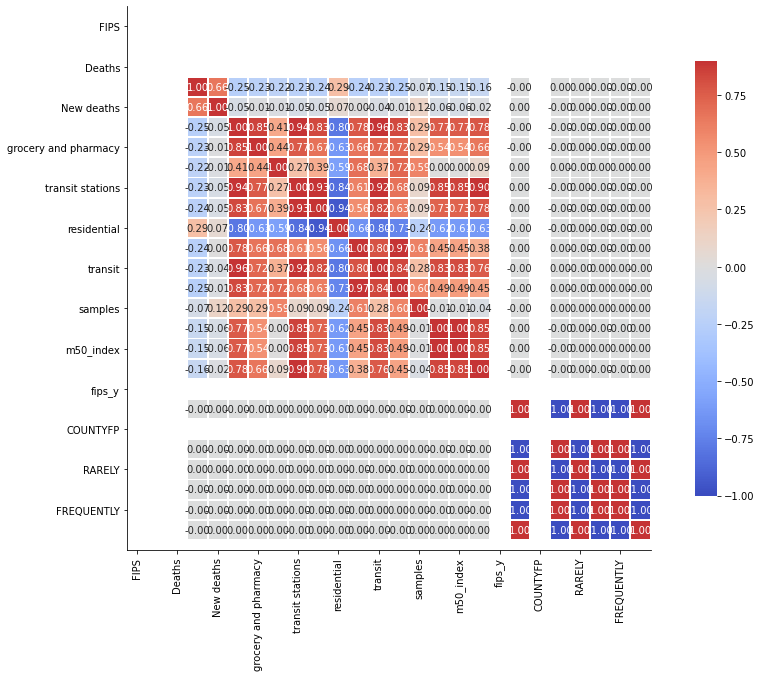

In [96]:
corr = queens_all_combined.corr()
g = sns.heatmap(corr, vmax=.9, center=0,
               square=True, linewidths=.9, cbar_kws={"shrink": .8}, annot=True, fmt='.2f', cmap='coolwarm')
bottom, top = g.get_ylim()
g.set_ylim(bottom + 0.5, top - 0.5)
sns.despine()
g.figure.set_size_inches(16, 10)

In [97]:
queens_all_combined.head()

,Date,FIPS,Confirmed,Deaths,New cases,New deaths,state,county,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,transit,walking,samples,m50,m50_index,rolling_average,fips_y,population_density,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,2020-03-01,36081.0,0,0,0,0,New York,Queens County,3.0,1.0,14.0,-4.0,1.0,0.0,-2.82,-17.33,-6.73,26218,1.339,35,NaN,36081,20767.142726,36081,0.022,0.023,0.068,0.136,0.751
1,2020-03-10,36081.0,0,0,150,0,New York,Queens County,4.0,10.0,33.0,-10.0,0.0,2.0,-0.55,-15.90,-1.27,28607,3.375,88,82.000000,36081,20767.142726,36081,0.022,0.023,0.068,0.136,0.751
2,2020-03-11,36081.0,0,0,70,1,New York,Queens County,5.0,12.0,38.0,-10.0,-1.0,2.0,-0.25,-17.24,-3.01,28585,3.495,91,80.857143,36081,20767.142726,36081,0.022,0.023,0.068,0.136,0.751
3,2020-03-12,36081.0,0,0,107,0,New York,Queens County,2.0,31.0,12.0,-14.0,-5.0,4.0,-3.93,-27.39,-11.14,28488,3.193,83,77.571429,36081,20767.142726,36081,0.022,0.023,0.068,0.136,0.751
4,2020-03-13,36081.0,0,0,94,1,New York,Queens County,-2.0,36.0,30.0,-18.0,-8.0,6.0,5.21,-28.31,0.81,27467,2.816,73,73.428571,36081,20767.142726,36081,0.022,0.023,0.068,0.136,0.751


In [98]:
columns = ['Date','FIPS','retail and recreation','grocery and pharmacy','parks','transit stations','workplaces','residential','driving','m50','m50_index','rolling_average','population_density','ALWAYS','New cases']
queens_all_filtered = queens_all_combined[columns]


In [99]:
queens_all_filtered.head()

,Date,FIPS,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,rolling_average,population_density,ALWAYS,New cases
0,2020-03-01,36081.0,3.0,1.0,14.0,-4.0,1.0,0.0,-2.82,1.339,35,NaN,20767.142726,0.751,0
1,2020-03-10,36081.0,4.0,10.0,33.0,-10.0,0.0,2.0,-0.55,3.375,88,82.000000,20767.142726,0.751,150
2,2020-03-11,36081.0,5.0,12.0,38.0,-10.0,-1.0,2.0,-0.25,3.495,91,80.857143,20767.142726,0.751,70
3,2020-03-12,36081.0,2.0,31.0,12.0,-14.0,-5.0,4.0,-3.93,3.193,83,77.571429,20767.142726,0.751,107
4,2020-03-13,36081.0,-2.0,36.0,30.0,-18.0,-8.0,6.0,5.21,2.816,73,73.428571,20767.142726,0.751,94


In [100]:
queens_all_filtered.to_csv('queens_all_filtered.csv',index=False)

## Pending work

- merged_socialDistancing and merged_mobility to be concatenated (done)
- add population and population density as two columns (done)
- mask as one column (done)
- In the final merged dataframe, try gini-index, PCA to determine the key features
- final modeling V1

- Overlap m50 with covid cases 
- Mask data doesn't have time series ; Take the value 
- Mobility data- 8 diff types of data; walking =0; workplace- high; residential - high-> plot

# Loading NY -county data 

In [101]:
NY_covidcases = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/NY-CovidAug22.csv', low_memory =False)
NY_covidcases.tail()

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths
12562,2020-08-17,New York,90036.0,0,0,0,0
12563,2020-08-18,New York,90036.0,0,0,0,0
12564,2020-08-19,New York,90036.0,0,0,0,0
12565,2020-08-20,New York,90036.0,0,0,0,0
12566,2020-08-21,New York,90036.0,0,0,0,0


In [102]:
#NY_covidcases['Date'] = NY_covidcases['Date'].apply(lambda x: fixDate(x))
NY_covidcases.reset_index(drop=True)
NY_covidcases.head(2)

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths
0,2020-01-22,New York,36001.0,0,0,0,0
1,2020-01-23,New York,36001.0,0,0,0,0


In [103]:
NY_covidcases['FIPS'] = NY_covidcases['FIPS'].apply(lambda x :int(x))

In [104]:
NY_covidcases.head(2)

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths
0,2020-01-22,New York,36001,0,0,0,0
1,2020-01-23,New York,36001,0,0,0,0


In [105]:
NY_covidcases.shape

(12567, 7)

## Combining mask data -NY county

In [106]:
NY_covidcases['mask_rule_active'] = NY_covidcases['Date'].apply(lambda x : 1 if x >= NY_mask_rule['Law Date'].values[0] else 0 )


In [107]:
#Mask
NY_mask = pd.merge(NY_covidcases,mask_data,how='inner',left_on=['FIPS'],right_on=['COUNTYFP'])
NY_mask.head(2)


,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths,mask_rule_active,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,2020-01-22,New York,36001,0,0,0,0,0,36001,0.006,0.012,0.052,0.142,0.788
1,2020-01-23,New York,36001,0,0,0,0,0,36001,0.006,0.012,0.052,0.142,0.788


In [108]:
NY_mask.shape

(12354, 14)

In [109]:
def updateMaskWearingPercent(x):
  #print(x)
  if x.mask_rule_active == 1:
    return x.ALWAYS
  else:
    return 0.0

In [110]:
NY_mask['mask_wearing_percent'] = NY_mask.apply(lambda x : updateMaskWearingPercent(x),axis=1)
 
NY_mask.tail()

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths,mask_rule_active,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,mask_wearing_percent
12349,2020-08-17,New York,36123,59,7,0,0,1,36123,0.0,0.006,0.023,0.087,0.884,0.884
12350,2020-08-18,New York,36123,59,7,0,0,1,36123,0.0,0.006,0.023,0.087,0.884,0.884
12351,2020-08-19,New York,36123,59,7,0,0,1,36123,0.0,0.006,0.023,0.087,0.884,0.884
12352,2020-08-20,New York,36123,59,7,0,0,1,36123,0.0,0.006,0.023,0.087,0.884,0.884
12353,2020-08-21,New York,36123,59,7,0,0,1,36123,0.0,0.006,0.023,0.087,0.884,0.884


In [111]:
NY_mask.head()

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths,mask_rule_active,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,mask_wearing_percent
0,2020-01-22,New York,36001,0,0,0,0,0,36001,0.006,0.012,0.052,0.142,0.788,0.0
1,2020-01-23,New York,36001,0,0,0,0,0,36001,0.006,0.012,0.052,0.142,0.788,0.0
2,2020-01-24,New York,36001,0,0,0,0,0,36001,0.006,0.012,0.052,0.142,0.788,0.0
3,2020-01-25,New York,36001,0,0,0,0,0,36001,0.006,0.012,0.052,0.142,0.788,0.0
4,2020-01-26,New York,36001,0,0,0,0,0,36001,0.006,0.012,0.052,0.142,0.788,0.0


## Combining population density data

In [112]:
# Pop density
#landarea_data[landarea_data['fips'] == 36081]['LND110210']

NY_landarea_df = pd.merge(NY_mask,landarea_data,how='inner',left_on=['FIPS'],right_on=['fips'])
NY_landarea_df.head(2)

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths,mask_rule_active,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,mask_wearing_percent,fips,PST045212,PST040210,PST120212,POP010210,AGE135212,AGE295212,AGE775212,SEX255212,RHI125212,RHI225212,RHI325212,RHI425212,RHI525212,RHI625212,RHI725212,RHI825212,POP715211,POP645211,POP815211,EDU635211,EDU685211,VET605211,LFE305211,HSG010211,HSG445211,HSG096211,HSG495211,HSD410211,HSD310211,INC910211,INC110211,PVY020211,BZA010211,BZA110211,BZA115211,NES010211,SBO001207,SBO315207,SBO115207,SBO215207,SBO515207,SBO415207,SBO015207,MAN450207,WTN220207,RTN130207,RTN131207,AFN120207,BPS030212,LND110210,POP060210
0,2020-01-22,New York,36001,0,0,0,0,0,36001,0.006,0.012,0.052,0.142,0.788,0.0,36001,305455,304206,0.4,304204,4.9,19.2,14.6,51.7,78.6,13.4,0.3,5.3,0.1,2.4,5.3,75.1,84.5,8.9,12.0,91.1,37.8,20729,19.9,138165,59.5,43.1,207300,123544,2.31,31728,57715,12.8,9436,168868,0.6,17635,24798,0.0,0.0,0.0,0.0,2.2,29.9,3351466,3642573,5404372,18121,738926,461,522.8,581.9
1,2020-01-23,New York,36001,0,0,0,0,0,36001,0.006,0.012,0.052,0.142,0.788,0.0,36001,305455,304206,0.4,304204,4.9,19.2,14.6,51.7,78.6,13.4,0.3,5.3,0.1,2.4,5.3,75.1,84.5,8.9,12.0,91.1,37.8,20729,19.9,138165,59.5,43.1,207300,123544,2.31,31728,57715,12.8,9436,168868,0.6,17635,24798,0.0,0.0,0.0,0.0,2.2,29.9,3351466,3642573,5404372,18121,738926,461,522.8,581.9


In [113]:
NY_landarea_df.shape

(12354, 67)

In [114]:
NY_landarea = pd.merge(NY_landarea_df,ny_population,how='inner',left_on=['FIPS'],right_on=['countyFIPS'])

NY_landarea.head(2)

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths,mask_rule_active,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,mask_wearing_percent,fips,PST045212,PST040210,PST120212,POP010210,AGE135212,AGE295212,AGE775212,SEX255212,RHI125212,RHI225212,RHI325212,RHI425212,RHI525212,RHI625212,RHI725212,RHI825212,POP715211,POP645211,POP815211,EDU635211,EDU685211,VET605211,LFE305211,HSG010211,HSG445211,HSG096211,HSG495211,HSD410211,HSD310211,INC910211,INC110211,PVY020211,BZA010211,BZA110211,BZA115211,NES010211,SBO001207,SBO315207,SBO115207,SBO215207,SBO515207,SBO415207,SBO015207,MAN450207,WTN220207,RTN130207,RTN131207,AFN120207,BPS030212,LND110210,POP060210,countyFIPS,County Name,State,population
0,2020-01-22,New York,36001,0,0,0,0,0,36001,0.006,0.012,0.052,0.142,0.788,0.0,36001,305455,304206,0.4,304204,4.9,19.2,14.6,51.7,78.6,13.4,0.3,5.3,0.1,2.4,5.3,75.1,84.5,8.9,12.0,91.1,37.8,20729,19.9,138165,59.5,43.1,207300,123544,2.31,31728,57715,12.8,9436,168868,0.6,17635,24798,0.0,0.0,0.0,0.0,2.2,29.9,3351466,3642573,5404372,18121,738926,461,522.8,581.9,36001,Albany County,NY,305506
1,2020-01-23,New York,36001,0,0,0,0,0,36001,0.006,0.012,0.052,0.142,0.788,0.0,36001,305455,304206,0.4,304204,4.9,19.2,14.6,51.7,78.6,13.4,0.3,5.3,0.1,2.4,5.3,75.1,84.5,8.9,12.0,91.1,37.8,20729,19.9,138165,59.5,43.1,207300,123544,2.31,31728,57715,12.8,9436,168868,0.6,17635,24798,0.0,0.0,0.0,0.0,2.2,29.9,3351466,3642573,5404372,18121,738926,461,522.8,581.9,36001,Albany County,NY,305506


In [115]:
NY_landarea.shape

(12354, 71)

In [116]:
NY_landarea['population_density']= NY_landarea['population']/NY_landarea['LND110210']
NY_landarea = NY_landarea[['Date','fips','New cases','County Name','State','mask_rule_active','mask_wearing_percent',  'population','LND110210','population_density']].copy()
NY_landarea.tail(3)

,Date,fips,New cases,County Name,State,mask_rule_active,mask_wearing_percent,population,LND110210,population_density
12351,2020-08-19,36123,0,Yates County,NY,1,0.884,24913,338.14,73.676584
12352,2020-08-20,36123,0,Yates County,NY,1,0.884,24913,338.14,73.676584
12353,2020-08-21,36123,0,Yates County,NY,1,0.884,24913,338.14,73.676584


## Combining mobility data 

In [117]:
# Mobility 
NY_mobility_data.head(2)

,state,county,date,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,transit,walking
0,New York,Total,2020-02-15,3.0,-4.0,-2.0,-4.0,1.0,0.0,25.10,13.64,46.70
1,New York,Total,2020-02-16,7.0,-3.0,13.0,0.0,0.0,-1.0,2.57,-4.20,25.33


In [118]:
NY_mobility_combined = pd.merge(NY_landarea,NY_mobility_data,how='inner',left_on=['Date','County Name'],right_on=['date','county'])
NY_mobility_combined.head(2)

,Date,fips,New cases,County Name,State,mask_rule_active,mask_wearing_percent,population,LND110210,population_density,state,county,date,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,transit,walking
0,2020-01-22,36001,0,Albany County,NY,0,0.0,305506,522.8,584.364958,New York,Albany County,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,8.37,51.62,46.03
1,2020-01-23,36001,0,Albany County,NY,0,0.0,305506,522.8,584.364958,New York,Albany County,2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,15.09,47.97,42.06


In [119]:
NY_mobility_combined.shape

(12141, 22)

## Combining social distancing 

In [120]:
newyork_socialdistancing_data.head(2)

,date,country_code,admin_level,admin1,admin2,fips,samples,m50,m50_index
320988,2020-03-01,US,2,New York,Albany County,36001.0,4095,2.616,54
320989,2020-03-02,US,2,New York,Albany County,36001.0,4376,4.680,97


In [121]:
newyork_socialdistancing_data['fips'] = newyork_socialdistancing_data['fips'].apply(lambda x:int(x))
newyork_socialdistancing_data.tail(2)

,date,country_code,admin_level,admin1,admin2,fips,samples,m50,m50_index
333430,2020-09-21,US,2,New York,Yates County,36123,537,7.511,108
333431,2020-09-22,US,2,New York,Yates County,36123,540,2.232,32


In [122]:
NY_mobility_combined.shape

(12141, 22)

In [123]:
NY_socialDistancing_combined = pd.merge(NY_mobility_combined,newyork_socialdistancing_data,how='inner',left_on=['Date','County Name'],right_on=['date','admin2'])
NY_socialDistancing_combined.head(2)

,Date,fips_x,New cases,County Name,State,mask_rule_active,mask_wearing_percent,population,LND110210,population_density,state,county,date_x,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,transit,walking,date_y,country_code,admin_level,admin1,admin2,fips_y,samples,m50,m50_index
0,2020-03-01,36001,0,Albany County,NY,0,0.0,305506,522.8,584.364958,New York,Albany County,2020-03-01,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,10.65,12.04,2020-03-01,US,2,New York,Albany County,36001,4095,2.616,54
1,2020-03-02,36001,0,Albany County,NY,0,0.0,305506,522.8,584.364958,New York,Albany County,2020-03-02,11.0,15.0,29.0,5.0,3.0,0.0,4.02,22.90,27.10,2020-03-02,US,2,New York,Albany County,36001,4376,4.680,97


In [124]:
NY_socialDistancing_combined.shape

(9804, 31)

## Filtering columns for feature selection

In [125]:
columns = ['Date','fips_x','County Name','population','retail and recreation','grocery and pharmacy','parks','transit stations','workplaces','residential','driving','m50','m50_index','population_density','mask_rule_active','mask_wearing_percent','New cases']
NY_All_combined = NY_socialDistancing_combined[columns]

NY_All_combined.head(2)


,Date,fips_x,County Name,population,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases
0,2020-03-01,36001,Albany County,305506,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,2.616,54,584.364958,0,0.0,0
1,2020-03-02,36001,Albany County,305506,11.0,15.0,29.0,5.0,3.0,0.0,4.02,4.680,97,584.364958,0,0.0,0


In [126]:
NY_All_combined.shape

(9804, 17)

In [127]:
NY_All_combined.to_csv('Newyork_combinedSep24.csv',index=False)


## Merging Social Distancing Inertia (Maryland data) and Covid data integration

In [128]:
NY_covidcases.dtypes

Date                object
Province_State      object
FIPS                 int64
Confirmed            int64
Deaths               int64
New cases            int64
New deaths           int64
mask_rule_active     int64
dtype: object

In [129]:
print(maryland_sd_inertia.shape)
NY_covidcases.shape

(732086, 45)


(12567, 8)

In [130]:
NY_socialDistancingInertiaData = pd.merge(NY_covidcases,maryland_sd_inertia,how='inner',left_on=['FIPS','Date'],right_on=['CTFIPS','date'])
print(NY_socialDistancingInertiaData.shape)

NY_socialDistancingInertiaData.head(2)

(12296, 53)


,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases
0,2020-01-22,New York,36001,0,0,0,0,0,36001,Albany County,36,20,21,4.32,40.3,2.3,35.4,1.06,3.25,0,307117,0.4,2020-01-22,6.06,22,64535,11.7,5.8,48.44,577,465,151,2.74,0.22,0.029,37.0,27,0.0,0,0.8,3.7,4.2,0.7,0.0,0.0,0.0,0,63.5,0.0,0.0,0.0,0,0
1,2020-01-23,New York,36001,0,0,0,0,0,36001,Albany County,36,15,19,4.46,39.6,2.5,37.9,1.08,3.38,0,307117,4.4,2020-01-23,6.06,22,64535,11.7,5.8,48.44,577,465,151,2.74,0.22,0.029,37.0,27,0.0,0,0.8,3.7,4.2,0.7,0.0,0.0,0.0,0,63.5,0.0,0.0,0.0,0,0


In [131]:
NY_socialDistancingInertiaData.to_csv("NY_socialDistancingInertiaDataSep24.csv",index=False)

# Feature Selection - Weightage

### Gini index

In [132]:
NY_All_combined = NY_All_combined.fillna(0)

In [133]:
def gini(list_of_values):
    sorted_list = sorted(list_of_values)
    height, area = 0, 0
    for value in sorted_list:
        height += value
        area += height - value / 2.
    fair_area = height * len(list_of_values) / 2.
    return (fair_area - area) / fair_area

In [134]:
# Calling gini-index method

feature_cols=['fips_x','retail and recreation','grocery and pharmacy',
              'parks','transit stations','workplaces','residential','driving',
              'm50','m50_index','population_density','mask_rule_active','mask_wearing_percent']
gini_values = {}
for col in feature_cols:
  dataset = NY_All_combined[col].values.tolist()
  #print(dataset)
  value = gini(dataset)
  print('cols ',col,' - gini coeff is :',value)
  gini_values[col] = value

cols  fips_x  - gini coeff is : 0.0005787570013044052
cols  retail and recreation  - gini coeff is : -0.8035661025099768
cols  grocery and pharmacy  - gini coeff is : 2.449901813458092
cols  parks  - gini coeff is : 1.0473317089279044
cols  transit stations  - gini coeff is : -0.9081616625375905
cols  workplaces  - gini coeff is : -0.3218529281537109
cols  residential  - gini coeff is : 0.5344880090115071
cols  driving  - gini coeff is : 0.9771209769750474
cols  m50  - gini coeff is : 0.43125446813012447
cols  m50_index  - gini coeff is : 0.4274082456359672
cols  population_density  - gini coeff is : 0.9094375804131932
cols  mask_rule_active  - gini coeff is : 0.2616279069767442
cols  mask_wearing_percent  - gini coeff is : 0.29170043757256686


In [135]:
sorted_x = sorted(gini_values.items(), key=lambda kv: kv[1])
sorted_x

[('transit stations', -0.9081616625375905),
 ('retail and recreation', -0.8035661025099768),
 ('workplaces', -0.3218529281537109),
 ('fips_x', 0.0005787570013044052),
 ('mask_rule_active', 0.2616279069767442),
 ('mask_wearing_percent', 0.29170043757256686),
 ('m50_index', 0.4274082456359672),
 ('m50', 0.43125446813012447),
 ('residential', 0.5344880090115071),
 ('population_density', 0.9094375804131932),
 ('driving', 0.9771209769750474),
 ('parks', 1.0473317089279044),
 ('grocery and pharmacy', 2.449901813458092)]

## Random Forest - Feature selection

In [136]:
queens_all_combined.describe().T

,count,mean,std,min,25%,50%,75%,max
FIPS,165.0,36081.000000,0.000000e+00,36081.000000,36081.000000,36081.000000,36081.000000,36081.000000
Confirmed,165.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
Deaths,165.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
New cases,165.0,7228.993939,2.251508e+04,0.000000,584.000000,831.000000,5238.000000,201385.000000
New deaths,165.0,107.612121,3.211897e+03,-18661.000000,8.000000,41.000000,335.000000,19033.000000
retail and recreation,165.0,-40.296970,2.097072e+01,-78.000000,-58.000000,-40.000000,-26.000000,8.000000
grocery and pharmacy,165.0,-8.769697,1.466147e+01,-48.000000,-20.000000,-7.000000,0.000000,36.000000
parks,165.0,72.612121,7.510640e+01,-63.000000,9.000000,71.000000,125.000000,247.000000
transit stations,165.0,-55.393939,1.796565e+01,-80.000000,-68.000000,-56.000000,-50.000000,-2.000000
workplaces,165.0,-45.909091,1.958684e+01,-75.000000,-60.000000,-48.000000,-40.000000,6.000000


In [137]:
X_cols = ['fips_x','retail and recreation','grocery and pharmacy','parks',
          'transit stations','workplaces','residential','driving','m50','m50_index',
          'population_density','mask_rule_active','mask_wearing_percent']
Y_cols = ['New cases']

In [138]:
x_train_c = NY_All_combined[X_cols]
y_train_c = NY_All_combined[Y_cols]

In [139]:
x_train_c

,fips_x,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent
0,36001,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,2.616,54,584.364958,0,0.000
1,36001,11.0,15.0,29.0,5.0,3.0,0.0,4.02,4.680,97,584.364958,0,0.000
2,36001,8.0,15.0,41.0,8.0,3.0,-1.0,12.09,4.778,100,584.364958,0,0.000
3,36001,7.0,8.0,6.0,2.0,3.0,0.0,11.97,4.486,93,584.364958,0,0.000
4,36001,5.0,13.0,18.0,2.0,3.0,-1.0,18.74,5.129,107,584.364958,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9799,36123,0.0,0.0,0.0,0.0,-23.0,0.0,281.57,4.181,60,73.676584,1,0.884
9800,36123,0.0,0.0,0.0,0.0,-23.0,0.0,276.14,3.576,51,73.676584,1,0.884
9801,36123,0.0,0.0,0.0,0.0,-22.0,0.0,350.22,6.347,91,73.676584,1,0.884
9802,36123,0.0,0.0,0.0,0.0,-21.0,0.0,320.75,6.822,98,73.676584,1,0.884


In [140]:
from sklearn.ensemble import RandomForestClassifier

# create the random forest with your hyperparameters.
rfc = RandomForestClassifier(n_estimators=150)

# fit the model to start training.
rfc.fit(x_train_c, y_train_c)

# get the importance of the resulting features.
f_importances = rfc.feature_importances_

# create a data frame for visualization.
final_df = pd.DataFrame({"Features": x_train_c.columns, "Importances":f_importances})

final_df.sort_values('Importances', ascending=False)

,Features,Importances
7,driving,0.120666
8,m50,0.115197
5,workplaces,0.103851
1,retail and recreation,0.102550
9,m50_index,0.101329
2,grocery and pharmacy,0.092837
10,population_density,0.080726
4,transit stations,0.075745
6,residential,0.072224
0,fips_x,0.042982


## Decision tree- feature selection

In [141]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel

clf = DecisionTreeClassifier()
clf = clf.fit(x_train_c, y_train_c)
f=clf.feature_importances_

final_dfs = pd.DataFrame({"Features": x_train_c.columns, "Importances":f})

final_dfs.sort_values('Importances', ascending=False)

,Features,Importances
7,driving,0.142905
5,workplaces,0.129432
8,m50,0.119263
2,grocery and pharmacy,0.103498
1,retail and recreation,0.099363
10,population_density,0.090194
9,m50_index,0.089045
4,transit stations,0.069746
6,residential,0.061970
3,parks,0.036296


## AutoML Implementation

In [142]:
X_cols = ['fips_x','retail and recreation','grocery and pharmacy','parks',
          'transit stations','workplaces','residential','driving','m50','m50_index',
          'population_density','mask_rule_active','mask_wearing_percent']


In [143]:
NY_All_combined['Date'] =  pd.to_datetime(NY_All_combined['Date'])

In [144]:
NY_All_combined.dtypes

Date                     datetime64[ns]
fips_x                            int64
County Name                      object
population                        int64
retail and recreation           float64
grocery and pharmacy            float64
parks                           float64
transit stations                float64
workplaces                      float64
residential                     float64
driving                         float64
m50                             float64
m50_index                         int64
population_density              float64
mask_rule_active                  int64
mask_wearing_percent            float64
New cases                         int64
dtype: object

In [145]:
X = NY_All_combined[X_cols]
Y = NY_All_combined[['New cases']]
Y.shape

(9804, 1)

In [146]:
X_train,X_test,Y_train, Y_test = train_test_split(X, Y,test_size=0.2, random_state=1)

In [147]:
num_folds = 12
seed = 7
scoring = 'accuracy'
models = []
models.append(('LR' , LogisticRegression()))
models.append(('LDA' , LinearDiscriminantAnalysis()))
models.append(('KNN' , KNeighborsClassifier()))
models.append(('CART' , DecisionTreeClassifier()))
models.append(('NB' , GaussianNB()))
models.append(('SVM' , SVC()))
models.append(('RF' , RandomForestClassifier(n_estimators=50)))
models.append(('XGBoost', XGBClassifier()))

In [148]:
Y_train.shape

(7843, 1)

In [149]:
results = []
names = []

for name, model in models:
    clf = model
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)
    accu_score = accuracy_score(Y_test, Y_pred)
    print(name + ": " + str(accu_score))

LR: 0.3712391636919939
LDA: 0.3671596124426313
KNN: 0.36359000509943906
CART: 0.3100458949515553
NB: 0.22641509433962265
SVM: 0.3717491075981642
RF: 0.36359000509943906
XGBoost: 0.3294237633860275


# Reference 

* https://medium.com/next-gen-machine-learning/feature-selection-best-methods-for-feature-selection-python-f3536aad5b4a